In [2]:
import sys
a = eval("['/home/hooton.f/.conda/envs/my-rdkit-env/lib/python36.zip', '/home/hooton.f/.conda/envs/my-rdkit-env/lib/python3.6', '/home/hooton.f/.conda/envs/my-rdkit-env/lib/python3.6/lib-dynload', '/home/hooton.f/.conda/envs/my-rdkit-env/lib/python3.6/site-packages']")
sys.path.extend(a)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

def clean_plot(leg=True, grid=None, font=None):
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    axis_color = 'lightgrey'
    ax.spines['bottom'].set_color(axis_color)
    ax.spines['left'].set_color(axis_color)
    ax.tick_params(axis='both', color=axis_color)
    
    if leg:
        ax.legend(frameon = False, loc='upper left', bbox_to_anchor=(1, 1))
        
    if grid is not None:
        plt.grid(color='lightgrey', axis = grid, linestyle='-', linewidth=.5)
        
    if font is not None:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels()):
            
            item.set_fontfamily(font['family'])
            item.set_color(font['color'])

In [5]:
d = pd.read_csv("BindingDB_All.tsv", sep='\t', error_bad_lines=False)

b'Skipping line 701045: expected 193 fields, saw 205\nSkipping line 701071: expected 193 fields, saw 205\n'
b'Skipping line 733764: expected 193 fields, saw 205\n'
b'Skipping line 756434: expected 193 fields, saw 265\n'
b'Skipping line 1160168: expected 193 fields, saw 241\n'
b'Skipping line 1274073: expected 193 fields, saw 241\nSkipping line 1274074: expected 193 fields, saw 241\nSkipping line 1274075: expected 193 fields, saw 241\nSkipping line 1274076: expected 193 fields, saw 241\nSkipping line 1274077: expected 193 fields, saw 241\nSkipping line 1274078: expected 193 fields, saw 241\nSkipping line 1274079: expected 193 fields, saw 241\nSkipping line 1274080: expected 193 fields, saw 241\nSkipping line 1274081: expected 193 fields, saw 241\n'
b'Skipping line 1287346: expected 193 fields, saw 205\n'
b'Skipping line 1306569: expected 193 fields, saw 241\nSkipping line 1306570: expected 193 fields, saw 241\nSkipping line 1306571: expected 193 fields, saw 241\nSkipping line 1306572: e

In [57]:
d = d[d['Target Source Organism According to Curator or DataSource'] == 'Homo sapiens']

In [61]:
dc = pd.DataFrame()
for c in ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)']:
    print(c, len(d[d[c].notnull()]))
    dc = dc.append({'Measure' : c, 'Num' : len(d[d[c].notnull()]), 'source' : 'd'}, ignore_index=True, sort=False)

Ki (nM) 224706
IC50 (nM) 585148
Kd (nM) 53974
EC50 (nM) 78908
kon (M-1-s-1) 509
koff (s-1) 404


In [22]:
db = pd.read_pickle('pubchem_ids.pkl')
db = db[db.target_amino.notnull()]
db.target_amino = db.target_amino.apply(lambda x: ''.join(x.split('\n')[1:]))

In [79]:
v = pd.read_pickle('viz_data.pkl')

In [81]:
len(set(v.cid.tolist()).intersection(set(d[d['PubChem CID'].notnull()]['PubChem CID'].tolist())))

4985

In [86]:
merged = v.merge(d, how='inner', left_on='cid', right_on='PubChem CID')
merged.to_pickle('bdb_cs_overlap.pkl')

In [58]:
merged = d.merge(db, how='inner', left_on=['PubChem CID','BindingDB Target Chain  Sequence'], right_on=['pubchem_id','target_amino']).drop_duplicates(['pubchem_id','target_amino', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)'])

In [84]:
for c in ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)']:
    print(c, len(merged[merged[c].notnull()]))
    dc = dc.append({'Measure' : c, 'Num' : len(merged[merged[c].notnull()]), 'source' : 'm'}, ignore_index=True, sort=False)

Ki (nM) 18848
IC50 (nM) 21329
Kd (nM) 32392
EC50 (nM) 3312
kon (M-1-s-1) 4
koff (s-1) 5


In [78]:
merged[['Ligand SMILES', 'Ligand InChI', 'BindingDB Ligand Name', 'Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)', 'PubChem CID',
   'Target Name Assigned by Curator or DataSource', 'BindingDB Target Chain  Sequence',
   'UniProt (SwissProt) Recommended Name of Target Chain']].to_pickle('bdb_drugbank.pkl')

In [60]:
dc.at[dc[dc['source'] == 'd'].index, 'dist'] = dc[dc['source'] == 'd'].Num / dc[dc['source'] == 'd'].Num.sum()
dc.at[dc[dc['source'] == 'm'].index, 'dist'] = dc[dc['source'] == 'm'].Num / dc[dc['source'] == 'm'].Num.sum()

dc.source = dc.source.str.replace('d', 'BindingDB')
dc.source = dc.source.str.replace('m', 'DrugBank')

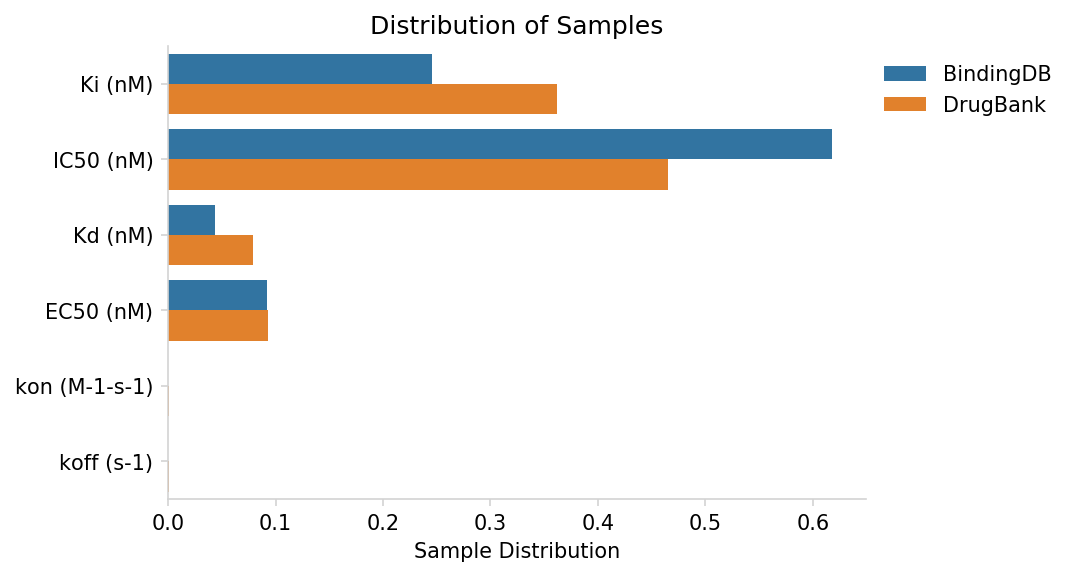

In [41]:
ax = sns.barplot(x = 'dist', y='Measure', data=dc, hue='source')

ax.set_ylabel('')
ax.set_xlabel('Sample Distribution')
ax.set_title('Distribution of Samples')

clean_plot()

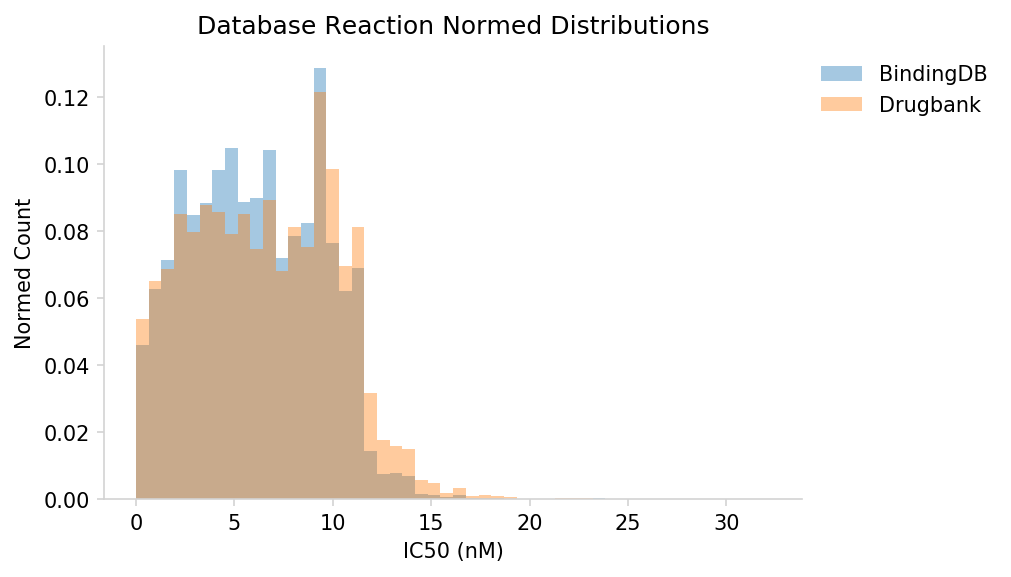

In [85]:
def clean_series(series):
    return series.str.lstrip('>').str.lstrip('<').dropna()

measure = 'IC50 (nM)'
# measure = 'Kd (nM)'

d_series = clean_series(d[measure]).apply(float).apply(lambda x: x+1).apply(np.log)
ax = sns.distplot(d_series, norm_hist=True, kde=False, label='BindingDB')

sns.distplot(clean_series(merged[measure]).apply(float).apply(lambda x: x+1).apply(np.log), norm_hist=True, kde=False, ax=ax, label='Drugbank')
# ax.set_xlim([-3, 16])
ax.set_ylabel('Normed Count')
ax.set_title('Database Reaction Normed Distributions')
plt.legend()
clean_plot()

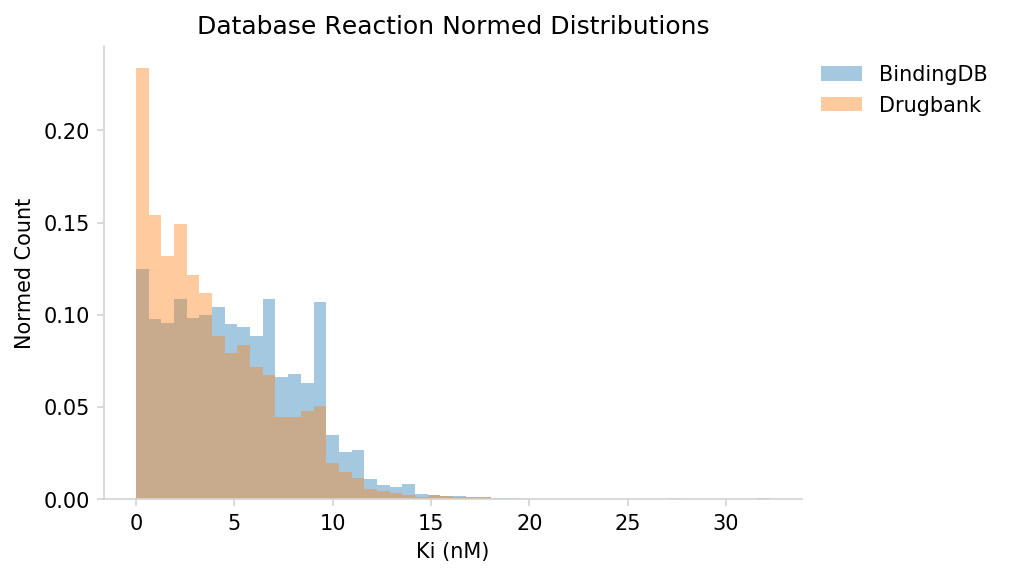

In [119]:
measure = 'Ki (nM)'

d_series = clean_series(d[measure]).apply(float).apply(lambda x: x+1).apply(np.log)
ax = sns.distplot(d_series, norm_hist=True, kde=False, label='BindingDB')

sns.distplot(clean_series(merged[measure]).apply(float).apply(lambda x: x+1).apply(np.log), norm_hist=True, kde=False, ax=ax, label='Drugbank')
# ax.set_xlim([-3, 16])
ax.set_ylabel('Normed Count')
ax.set_title('Database Reaction Normed Distributions')
plt.legend()
clean_plot()

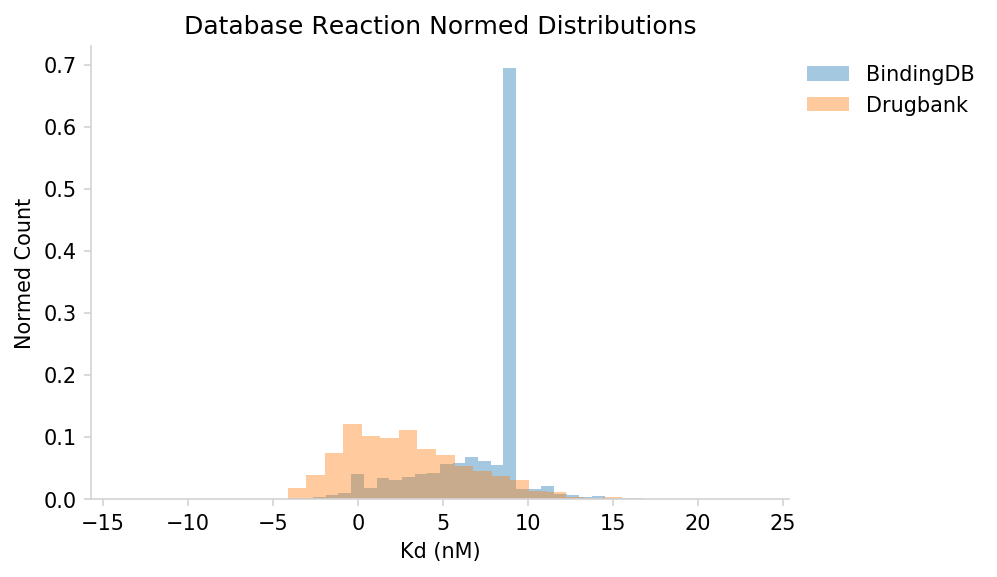

In [120]:
measure = 'IC50 (nM)'
measure = 'Kd (nM)'

d_series = clean_series(d[measure]).apply(float).apply(np.log)
ax = sns.distplot(d_series, norm_hist=True, kde=False, label='BindingDB')

sns.distplot(clean_series(merged[measure]).apply(float).apply(np.log), norm_hist=True, kde=False, ax=ax, label='Drugbank')
# ax.set_xlim([-3, 16])
ax.set_ylabel('Normed Count')
ax.set_title('Database Reaction Normed Distributions')
plt.legend()
clean_plot()

AttributeError: Can only use .str accessor with string values, which use np.object_ dtype in pandas

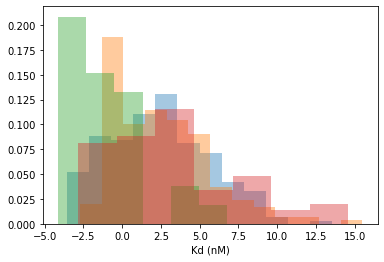

In [100]:
merged2 = merged[merged.target_actions.notnull()]
merged2.target_actions = merged2.target_actions.apply(lambda x: x[0].lower())


_, ax = plt.subplots()
for ta in merged2.target_actions.drop_duplicates().tolist():
    if len(clean_series(merged2[merged2.target_actions == ta]['Kd (nM)'])) < 10:
        continue
    
    sns.distplot(clean_series(merged2[merged2.target_actions == ta]['Kd (nM)']).apply(float).apply(np.log), norm_hist=True, kde=False, label=ta, ax=ax)

# ax.set_xlim([-3, 16])
ax.set_ylabel('Normed Count')
ax.set_title('Drugbank Reaction Normed Distributions')
plt.legend()
# clean_plot(leg=False)

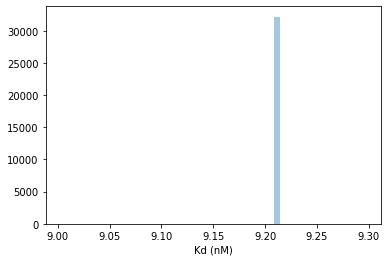

In [107]:
sns.distplot(d_series[d_series.between(9.2,9.25)], kde=False)

In [109]:
d_series[d_series.between(9.2,9.25)].apply(np.exp)

24190      10000.0
24199      10000.0
24209      10000.0
24224      10000.0
24226      10000.0
24239      10000.0
24242      10000.0
24243      10000.0
24244      10000.0
24245      10000.0
24246      10000.0
24254      10000.0
24255      10000.0
24256      10000.0
46518      10233.0
126594     10000.0
154842     10000.0
219671     10000.0
219675     10000.0
219676     10000.0
219683     10000.0
219697     10000.0
219714     10000.0
219762     10000.0
306733      9900.0
322613     10200.0
342547     10000.0
348212     10000.0
350355     10000.0
364055     10000.0
            ...   
1649798    10233.0
1651784    10000.0
1651801    10000.0
1656831    10100.0
1657162    10000.0
1661304    10000.0
1661519    10000.0
1662200    10000.0
1662204    10000.0
1662222    10000.0
1662223    10000.0
1662224    10000.0
1662225    10000.0
1662226    10000.0
1662228    10000.0
1662229    10000.0
1662230    10000.0
1662233    10000.0
1667177    10000.0
1668318    10000.0
1672277    10000.0
1672842    1

In [124]:
print(len(d_series[d_series<5]), len(d_series))

13336 65472


In [13]:
for i, c in enumerate(d.columns.tolist()):
    print(i, c)

0 BindingDB Reactant_set_id
1 Ligand SMILES
2 Ligand InChI
3 Ligand InChI Key
4 BindingDB MonomerID
5 BindingDB Ligand Name
6 Target Name Assigned by Curator or DataSource
7 Target Source Organism According to Curator or DataSource
8 Ki (nM)
9 IC50 (nM)
10 Kd (nM)
11 EC50 (nM)
12 kon (M-1-s-1)
13 koff (s-1)
14 pH
15 Temp (C)
16 Curation/DataSource
17 Article DOI
18 PMID
19 PubChem AID
20 Patent Number
21 Authors
22 Institution
23 Link to Ligand in BindingDB
24 Link to Target in BindingDB
25 Link to Ligand-Target Pair in BindingDB
26 Ligand HET ID in PDB
27 PDB ID(s) for Ligand-Target Complex
28 PubChem CID
29 PubChem SID
30 ChEBI ID of Ligand
31 ChEMBL ID of Ligand
32 DrugBank ID of Ligand
33 IUPHAR_GRAC ID of Ligand
34 KEGG ID of Ligand
35 ZINC ID of Ligand
36 Number of Protein Chains in Target (>1 implies a multichain complex)
37 BindingDB Target Chain  Sequence
38 PDB ID(s) of Target Chain
39 UniProt (SwissProt) Recommended Name of Target Chain
40 UniProt (SwissProt) Entry Name of T

In [14]:
len(d[d['PubChem CID'].notnull()]) / len(d)

0.9960308489192453

In [45]:
t = d[d['IC50 (nM)'].notnull()].copy()
t['IC50 (nM)'] = t['IC50 (nM)'].str.lstrip('>').str.lstrip('<').apply(float)
len(t[t['IC50 (nM)'] < 7]), len(t[t['IC50 (nM)'] >= 7])

(132004, 922635)

In [48]:
d_series

142        10.819798
144         8.806559
180         2.251292
181         5.181784
183         5.105945
184         4.219508
185         3.332205
186         4.043051
187         4.219508
188         4.343805
189         5.017280
190         4.143135
191         4.905275
192         3.178054
193         3.465736
194         3.737670
195         3.637586
196         3.912023
197         4.844187
332         2.687847
333         2.240710
334         4.060443
335         4.601162
336         3.335770
337         3.891820
338         4.526127
339         4.334673
340         3.937691
341         3.157000
342         2.667228
             ...    
1707381     8.240385
1707382     4.948760
1707383     5.081404
1707384     9.674137
1707385     8.513386
1707387     7.824446
1707388     9.756784
1707389    10.305647
1707390     9.607841
1707391     9.358847
1707392     9.848028
1707393    10.819798
1707394    10.574159
1707395    10.819798
1707396     5.198497
1707397    10.836262
1707398     9

In [70]:
def clean_series(series):
    return series.str.lstrip('>').str.lstrip('<').dropna()

measure = 'IC50 (nM)'

dl = d[d[measure].notnull()].copy()

dl[measure] = clean_series(dl[measure]).apply(float)
dl = dl[dl['UniProt (SwissProt) Recommended Name of Target Chain'].notnull()]

In [72]:
dl[['Ligand SMILES', 'Ligand InChI', 'BindingDB Ligand Name', 'IC50 (nM)', 'PubChem CID',
   'Target Name Assigned by Curator or DataSource', 'BindingDB Target Chain  Sequence',
   'UniProt (SwissProt) Recommended Name of Target Chain']]

,Ligand SMILES,Ligand InChI,BindingDB Ligand Name,IC50 (nM),PubChem CID,Target Name Assigned by Curator or DataSource,BindingDB Target Chain Sequence,UniProt (SwissProt) Recommended Name of Target Chain
142,Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...,InChI=1S/C19H22ClN9O/c1-11-13(9-27(3)25-11)18-...,"US9447092, 3",50000.00,71463198.0,Cytochrome P450 3A,MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...,Cytochrome P450 3A4
1899,CC1(O)CN(CCC11CCN(C1=O)c1ccc(OC(F)(F)F)cc1)S(=...,"InChI=1S/C22H22ClF3N2O5S/c1-20(30)14-27(34(31,...","US8470843, 13::US8470843, 14",740.00,56602769.0,Hormone-sensitive lipase (HSL),MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...,Hormone-sensitive lipase
1960,Fc1ccc(cc1)C1(CC1)C(=O)N1CC2CC2(C1)c1c[nH]c2nc...,InChI=1S/C22H20FN3O/c23-16-5-3-14(4-6-16)21(7-...,"CHEMBL2070316::US8486964, 1",26.00,44814425.0,11-beta-hydroxysteroid dehydrogenase 1,MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...,Corticosteroid 11-beta-dehydrogenase isozyme 1
2862,CNC(=O)c1ccc2[C@H]3CCCN([C@H]3Cc2c1)C(=O)c1ccc...,InChI=1S/C22H22N4O2/c1-23-21(27)13-4-6-16-15(9...,"US8497281, 101",712.00,67223164.0,11-beta-hydroxysteroid dehydrogenase 1,MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...,Corticosteroid 11-beta-dehydrogenase isozyme 1
2869,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCNCCc4c3)nc12,InChI=1S/C24H23N7/c1-30-22-6-2-4-19(21(22)15-2...,"US8501936, 298",1033.14,49838143.0,Focal adhesion kinase 1,MAAAYLDPNLNHTPNSSTKTHLGTGMERSPGAMERVLKVFHYFESN...,Focal adhesion kinase 1
2875,CN(C)C(=O)N1CCc2ccc(Nc3nc4c(cccn4n3)-c3cc(Cl)c...,InChI=1S/C27H27ClF2N6O2/c1-34(2)27(37)35-12-9-...,"US8501936, 382",1999.00,59612556.0,Focal adhesion kinase 1,MAAAYLDPNLNHTPNSSTKTHLGTGMERSPGAMERVLKVFHYFESN...,Focal adhesion kinase 1
2879,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,"InChI=1S/C29H31N7O2/c1-29(2,3)38-28(37)35-15-1...","US8501936, 298::US8501936, 300",16.54,59612433.0,Tyrosine-protein kinase JAK2,MGMACLTMTEMEGTSTSSIYQNGDISGNANSMKQIDPVLQVYLYHS...,Tyrosine-protein kinase JAK2
2952,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,"InChI=1S/C29H31N7O2/c1-29(2,3)38-28(37)35-15-1...","US8501936, 298::US8501936, 300",226.90,59612433.0,Tyrosine-protein kinase JAK3,MAPPSEETPLIPQRSCSLLSTEAGALHVLLPARGPGPPQRLSFSFG...,Tyrosine-protein kinase JAK3
3037,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,"InChI=1S/C29H31N7O2/c1-29(2,3)38-28(37)35-15-1...","US8501936, 298::US8501936, 300",2999.00,59612433.0,Focal adhesion kinase 1,MAAAYLDPNLNHTPNSSTKTHLGTGMERSPGAMERVLKVFHYFESN...,Focal adhesion kinase 1
3038,Cn1ncc2c(cccc12)-c1cccn2nc(Nc3ccc4CCN(CCc4c3)C...,"InChI=1S/C29H31N7O2/c1-29(2,3)38-28(37)35-15-1...","US8501936, 298::US8501936, 300",16.51,59612433.0,Tyrosine-protein kinase JAK2,MGMACLTMTEMEGTSTSSIYQNGDISGNANSMKQIDPVLQVYLYHS...,Tyrosine-protein kinase JAK2


In [73]:
dl.columns.tolist()

['BindingDB Reactant_set_id',
 'Ligand SMILES',
 'Ligand InChI',
 'Ligand InChI Key',
 'BindingDB MonomerID',
 'BindingDB Ligand Name',
 'Target Name Assigned by Curator or DataSource',
 'Target Source Organism According to Curator or DataSource',
 'Ki (nM)',
 'IC50 (nM)',
 'Kd (nM)',
 'EC50 (nM)',
 'kon (M-1-s-1)',
 'koff (s-1)',
 'pH',
 'Temp (C)',
 'Curation/DataSource',
 'Article DOI',
 'PMID',
 'PubChem AID',
 'Patent Number',
 'Authors',
 'Institution',
 'Link to Ligand in BindingDB',
 'Link to Target in BindingDB',
 'Link to Ligand-Target Pair in BindingDB',
 'Ligand HET ID in PDB',
 'PDB ID(s) for Ligand-Target Complex',
 'PubChem CID',
 'PubChem SID',
 'ChEBI ID of Ligand',
 'ChEMBL ID of Ligand',
 'DrugBank ID of Ligand',
 'IUPHAR_GRAC ID of Ligand',
 'KEGG ID of Ligand',
 'ZINC ID of Ligand',
 'Number of Protein Chains in Target (>1 implies a multichain complex)',
 'BindingDB Target Chain  Sequence',
 'PDB ID(s) of Target Chain',
 'UniProt (SwissProt) Recommended Name of Tar

In [71]:
dl[['Ligand SMILES', 'Ligand InChI', 'BindingDB Ligand Name', 'IC50 (nM)', 'PubChem CID',
   'Target Name Assigned by Curator or DataSource', 'BindingDB Target Chain  Sequence',
   'UniProt (SwissProt) Recommended Name of Target Chain']].to_pickle('val.pkl')

In [69]:
dl[dl['UniProt (SwissProt) Recommended Name of Target Chain'].isnull()]

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name Assigned by Curator or DataSource,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
10838,10839,O=C(Nc1ccccn1)Nc1cccc2C(=O)N3CCC[C@@H]3c12,InChI=1S/C17H16N4O2/c22-16-11-5-3-6-12(15(11)1...,KLVYMYQTRZCMLE-CYBMUJFWSA-N,6619,"3-[(9bR)-5-oxo-1H,2H,3H,5H,9bH-benzo[a]pyrroli...",Cyclin-Dependent Kinase 6 (CDK6),Homo sapiens,NaN,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12919,12920,CCOc1cccc(n1)N1CC(C1)Oc1ccc(cc1)[C@H](C)NC(C)=O,InChI=1S/C20H25N3O3/c1-4-25-20-7-5-6-19(22-20)...,OUJDLADNJRGDKW-AWEZNQCLSA-N,5922,"US8530460, 4.11",Acetyl-CoA carboxylase 2 (ACC2),Homo sapiens,NaN,3620.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13516,13517,CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...,InChI=1S/C60H74N12O6/c1-37(61-3)57(75)65-47-35...,DRYVJXANNWHFGX-GJQZLFHCSA-N,130050,"US8815927, SM-1266",cIAP-2 BIR3,Homo sapiens,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13519,13520,CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...,InChI=1S/C62H78N12O7/c1-39(63-3)59(77)67-49-37...,ZPYWWTKXCOYJBE-LLUFGHGUSA-N,130048,"US8815927, SM-1259",cIAP-2 BIR3,Homo sapiens,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13940,13941,CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...,InChI=1S/C58H70N12O6/c1-35(59-3)55(73)63-45-33...,QWLVLLKEBKWIRS-HCTRBPPDSA-N,130049,"US8815927, SM-1265",cIAP-2 BIR3,Homo sapiens,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14002,14003,CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...,InChI=1S/C62H78N12O6/c1-39(63-3)59(77)67-49-37...,WXBHQQMXKHAAIH-LLUFGHGUSA-N,130051,"US8815927, SM-1267",cIAP-2 BIR3,Homo sapiens,NaN,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14159,14160,CN[C@@H](C)C(=O)N[C@H]1CN(CC[C@H]2CC[C@H](N2C1...,NaN,NaN,7006,"US8815927, SM-1258",cIAP-2 BIR3,Homo sapiens,NaN,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21770,21771,NS(=O)(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2)cc1,"InChI=1S/C18H22N6O3S/c19-28(25,26)14-8-6-13(7-...",OWXORKPNCHJYOF-UHFFFAOYSA-N,5544,4-{[6-(cyclohexylmethoxy)-9H-purin-2-yl]amino}...,Cyclin-Dependent Kinase 2 (CDK2) Mutant (K89T),Homo sapiens,NaN,8.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21771,21772,NS(=O)(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2)cc1,"InChI=1S/C18H22N6O3S/c19-28(25,26)14-8-6-13(7-...",OWXORKPNCHJYOF-UHFFFAOYSA-N,5544,4-{[6-(cyclohexylmethoxy)-9H-purin-2-yl]amino}...,Cyclin-Dependent Kinase 2 (CDK2) Mutant (L83V/...,Homo sapiens,NaN,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21772,21773,NS(=O)(=O)c1ccc(Nc2nc(OCC3CCCCC3)c3[nH]cnc3n2)cc1,"InChI=1S/C18H22N6O3S/c19-28(25,26)14-8-6-13(7-...",OWXORKPNCHJYOF-UHFFFAOYSA-N,5544,4-{[6-(cyclohexylmethoxy)-9H-purin-2-yl]amino}...,Cyclin-Dependent Kinase 2 (CDK2) Mutant (F82H),Homo sapiens,NaN,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
